In [1]:
# update the git
! git add  .
! git commit -m "From Mac"
! git push

The file will have its original line endings in your working directory.
The file will have its original line endings in your working directory.


[master 6392651f] From Mac
 2 files changed, 858 insertions(+), 964 deletions(-)
 rewrite NeuralNetwork/AAE/9 guassian .ipynb (64%)


To https://github.com/JaeDukSeo/Daily-Neural-Network-Practice-2
   e9af6bb4..6392651f  master -> master


In [2]:
# import library
import matplotlib 
matplotlib.use('Agg')
%matplotlib inline
import numpy as np
import sys, os,cv2
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from skimage.transform import resize
from scipy.misc import imread
from imgaug import augmenters as iaa
import nibabel as nib
import imgaug as ia
from scipy.ndimage import zoom
from sklearn.utils import shuffle
import matplotlib.animation as animation

# Generate training data
import tensorflow as tf
old_v = tf.logging.get_verbosity()
tf.logging.set_verbosity(tf.logging.ERROR)
from tensorflow.examples.tutorials.mnist import input_data

plt.style.use('seaborn-white')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
np.random.seed(6278)
tf.set_random_seed(6728)
ia.seed(6278)

In [3]:
# get the mnist data set
mnist = input_data.read_data_sets('../../Dataset/MNIST/', one_hot=True)
x_data, train_label, y_data, test_label = mnist.train.images, mnist.train.labels, mnist.test.images, mnist.test.labels
x_data_added,x_data_added_label = mnist.validation.images,mnist.validation.labels
x_data = x_data.reshape(-1, 28, 28, 1)  # 28x28x1 input img
y_data = y_data.reshape(-1, 28, 28, 1)  # 28x28x1 input img
x_data_added = x_data_added.reshape(-1, 28, 28, 1)
x_data = np.vstack((x_data,x_data_added))
train_label = np.vstack((train_label,x_data_added_label))

train_batch = np.zeros((20000,28,28,1))
test_batch = np.zeros((10000,28,28,1))
for iter in range(20000):
    train_batch[iter,:,:,:] = np.expand_dims(resize(x_data[iter,:,:,0],(28,28)),axis=3)

# print out the data shape and the max and min value
print(train_batch.shape)
print(train_batch.max())
print(train_batch.min())
print(train_label.shape)
print(train_label.max())
print(train_label.min())
print(test_batch.shape)
print(test_batch.max())
print(test_batch.min())
print(test_label.shape)
print(test_label.max())
print(test_label.min())

Extracting ../../Dataset/MNIST/train-images-idx3-ubyte.gz
Extracting ../../Dataset/MNIST/train-labels-idx1-ubyte.gz
Extracting ../../Dataset/MNIST/t10k-images-idx3-ubyte.gz
Extracting ../../Dataset/MNIST/t10k-labels-idx1-ubyte.gz


C:\ProgramData\Anaconda3\lib\site-packages\skimage\transform\_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\ProgramData\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  


(20000, 28, 28, 1)
1.0
0.0
(60000, 10)
1.0
0.0
(10000, 28, 28, 1)
0.0
0.0
(10000, 10)
1.0
0.0


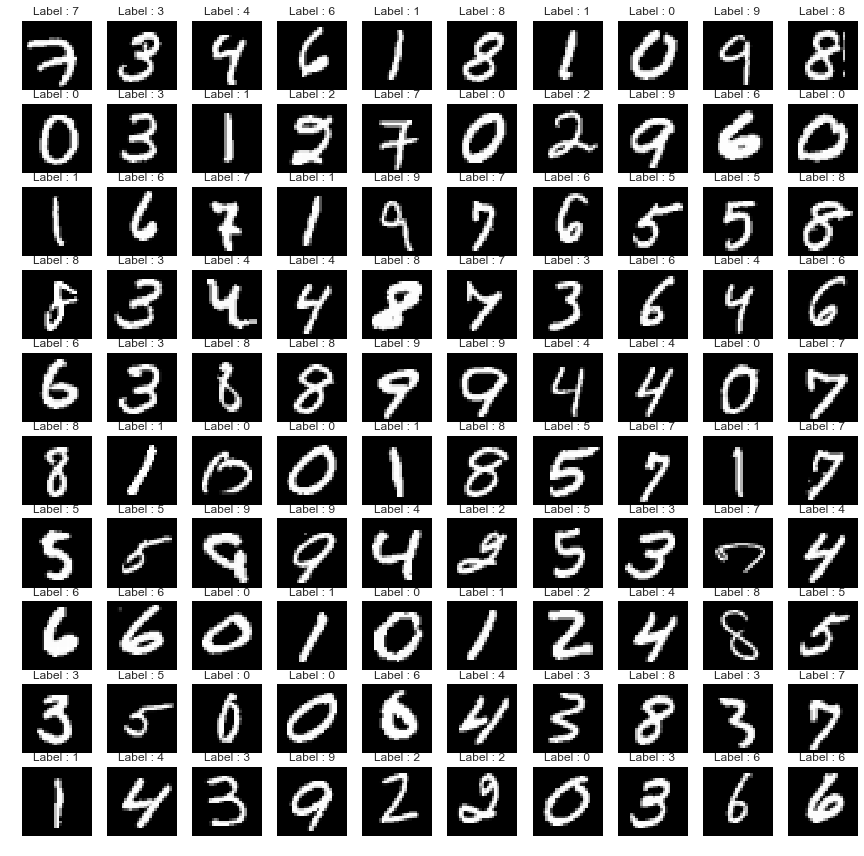

In [4]:
# show small amount of data
fig=plt.figure(figsize=(15, 15))
columns = 10 ; rows = 10
for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    plt.imshow(np.squeeze(train_batch[i-1]),cmap='gray')
    plt.axis('off')
    plt.title("Label : "+str(np.argmax(train_label[i-1])))
plt.show()

In [5]:
# import all of the layers
def tf_elu(x):
    """ Exponential Linear Unit based on the ICCV 2015 paper
    https://arxiv.org/pdf/1511.07289.pdf

    Parameters
    ----------
    x : float
        The floating point number that is going to be applied to the ELU activation.

    Returns
    -------
    float
        Data with the same dimensions as the input after ELU

    """
    return tf.nn.elu(x)
def d_tf_elu(x):
    """Derivative of the Exponential Linear Unit base on the ICCV 2015 paper
    https://arxiv.org/pdf/1511.07289.pdf

    Parameters
    ----------
    x : type
        Description of parameter `x`.

    Returns
    -------
    type
        Description of returned object.

    """

    return tf.cast(tf.greater(x,0),tf.float32)  + (tf_elu(tf.cast(tf.less_equal(x,0),tf.float32) * x) + 1.0)

def tf_identiy(x)  : return x
def d_tf_identiy(x): return tf.ones_like(x,dtype=tf.float32)

def tf_relu(x):   return tf.nn.relu(x)
def d_tf_relu(x): return tf.cast(tf.greater(x,0.0),tf.float32)

def tf_lrelu(x): return tf.nn.leaky_relu(x,alpha=0.2)
def d_tf_lrelu(x): return tf.cast(tf.greater(x,0),tf.float32) + tf.cast(tf.less_equal(x,0),tf.float32) * 0.2

def tf_tanh(x): return tf.nn.tanh(x)
def d_tf_tanh(x): return 1 - tf_tanh(x) ** 2

def tf_sigmoid(x):   return tf.nn.sigmoid(x)
def d_tf_sigmoid(x): return tf_sigmoid(x) * (1.0-tf_sigmoid(x))

def tf_atan(x): return tf.atan(x)
def d_tf_atan(x): return 1.0/(1.0 + x**2)

def tf_softmax(x): return tf.nn.softmax(x)
def softabs(x): return tf.sqrt(x ** 2 + 1e-20)

def tf_logcosh(x): return tf.log(tf.cosh(x))
def d_tf_logcosh(x): return tf.tanh(x)

class FNN():

    def __init__(self,inc,outc,stddev=None,act=tf_elu,d_act=d_tf_elu,which_reg=0,init_x=False):
        if init_x:
            interval = np.sqrt(6.0 / (inc + outc + 1.0))
            self.w = tf.Variable(tf.random_uniform(shape=(inc, outc),minval=-interval,maxval=interval,dtype=tf.float32,seed=2))
            self.b = tf.Variable(tf.zeros(shape=[outc],dtype=tf.float32))
        else:
            self.w = tf.Variable(tf.random_normal([inc,outc],stddev=stddev,seed=2,dtype=tf.float32))
            self.b = tf.Variable(tf.zeros([outc],dtype=tf.float32))

        self.m,  self.v   = tf.Variable(tf.zeros_like(self.w)),tf.Variable(tf.zeros_like(self.w))
        self.m_b,self.v_b = tf.Variable(tf.zeros_like(self.b)),tf.Variable(tf.zeros_like(self.b))
        self.act,self.d_act = act,d_act
        self.which_reg = which_reg

    def getw(self): return self.w

    def feedforward(self,input=None):
        self.input  = input
        self.layer  = tf.matmul(input,self.w) + self.b
        self.layerA = self.act(self.layer)
        return self.layerA

    def backprop(self,gradient=None,learning_rate=None):
        grad_part_1 = gradient
        grad_part_2 = self.d_act(self.layer)
        grad_part_3 = self.input

        grad_middle = grad_part_1 * grad_part_2
        grad  = tf.matmul(tf.transpose(grad_part_3),grad_middle)/batch_size
        grad_b= tf.reduce_mean(grad_middle,0)/batch_size
        grad_pass = tf.matmul(grad_middle,tf.transpose(self.w))

        update_w = []
        update_w.append(tf.assign( self.m,self.m*beta1 + (1-beta1) * (grad)   ))
        update_w.append(tf.assign( self.v,self.v*beta2 + (1-beta2) * (grad ** 2)   ))
        m_hat = self.m / (1.-beta1)
        v_hat = self.v / (1.-beta2)
        adam_middle  = m_hat     *  learning_rate/(tf.sqrt(v_hat) + adam_e)
        update_w.append(tf.assign(self.w,tf.subtract(self.w,adam_middle )))

        update_w.append(tf.assign(self.m_b,self.m_b*beta1 + (1-beta1) * (grad_b)   ))
        update_w.append(tf.assign(self.v_b,self.v_b*beta2 + (1-beta2) * (grad_b ** 2)   ))
        m_hat_b = self.m_b / (1-beta1)
        v_hat_b = self.v_b / (1-beta2)
        adam_middle_b = m_hat_b *  learning_rate/(tf.sqrt(v_hat_b) + adam_e)
        update_w.append(tf.assign(self.b,tf.subtract(self.b,adam_middle_b ))) 
        
        return grad_pass,update_w

class CNN():

    def __init__(self,k,inc,out,stddev=0.005,which_reg=0,act=tf_elu,d_act=d_tf_elu,residual=False):
        self.w = tf.Variable(tf.random_normal([k,k,inc,out],stddev=stddev,seed=2,dtype=tf.float32))
        self.m,self.v = tf.Variable(tf.zeros_like(self.w)),tf.Variable(tf.zeros_like(self.w))
        self.act,self.d_act = act,d_act
        self.which_reg = which_reg
        self.residual = residual

    def getw(self): return self.w

    def feedforward(self,input,stride=1,padding='VALID'):
        self.input  = input
        if self.residual: 
            self.layer  = tf.nn.conv2d(input,self.w,strides=[1,stride,stride,1],padding='SAME')
            self.layerA = self.act(self.layer) + input
        else:
            self.layer  = tf.nn.conv2d(input,self.w,strides=[1,stride,stride,1],padding=padding)
            self.layerA = self.act(self.layer)
        return self.layerA

    def backprop(self,gradient,stride=1,padding='VALID'):
        grad_part_1 = gradient
        grad_part_2 = self.d_act(self.layer)
        grad_part_3 = self.input

        grad_middle = grad_part_1 * grad_part_2

        if self.residual: 
            grad = tf.nn.conv2d_backprop_filter(input = grad_part_3,filter_sizes = self.w.shape,out_backprop = grad_middle,
                strides=[1,stride,stride,1],padding='SAME'
            ) / batch_size
            
            grad_pass = tf.nn.conv2d_backprop_input(input_sizes = [batch_size] + list(grad_part_3.shape[1:]),filter= self.w,out_backprop = grad_middle,
                strides=[1,stride,stride,1],padding='SAME'
            ) + gradient
        else: 
            grad = tf.nn.conv2d_backprop_filter(input = grad_part_3,filter_sizes = self.w.shape,out_backprop = grad_middle,
                strides=[1,stride,stride,1],padding=padding
            ) / batch_size
        
            grad_pass = tf.nn.conv2d_backprop_input(input_sizes = [batch_size] + list(grad_part_3.shape[1:]),filter= self.w,out_backprop = grad_middle,
                strides=[1,stride,stride,1],padding=padding
            )

        # === Reg ===        
        if self.which_reg == 0:
            grad = grad

        if self.which_reg == 0.5:
            grad = grad + lamda * (tf.sqrt(tf.abs(self.w))) * (1.0/tf.sqrt(tf.abs(self.w)+ 10e-5)) * tf.sign(self.w)

        if self.which_reg == 1:
            grad = grad + lamda * tf.sign(self.w)

        if self.which_reg == 1.5:
            grad = grad + lamda * 1.0/(tf.sqrt(tf.square(self.w) + 10e-5)) * self.w

        if self.which_reg == 2:
            grad = grad + lamda * (1.0/tf.sqrt(tf.square(tf.abs(self.w))+ 10e-5)) * tf.abs(self.w) * tf.sign(self.w)

        if self.which_reg == 2.5:
            grad = grad + lamda * 2.0 * self.w

        if self.which_reg == 3:
            grad = grad + lamda * tf.pow(tf.pow(tf.abs(self.w),3)+ 10e-5,-0.66) * tf.pow(tf.abs(self.w),2) * tf.sign(self.w)

        if self.which_reg == 4:
            grad = grad + lamda * tf.pow(tf.pow(tf.abs(self.w),4)+ 10e-5,-0.75) * tf.pow(tf.abs(self.w),3) * tf.sign(self.w)

        update_w = []
        update_w.append(tf.assign( self.m,self.m*beta1 + (1-beta1) * (grad)   ))
        update_w.append(tf.assign( self.v,self.v*beta2 + (1-beta2) * (grad ** 2)   ))
        m_hat = self.m / (1-beta1)
        v_hat = self.v / (1-beta2)
        adam_middel = learning_rate/(tf.sqrt(v_hat) + adam_e)
        update_w.append(tf.assign(self.w,tf.subtract(self.w,tf.multiply(adam_middel,m_hat)  )))
        return grad_pass,update_w

In [6]:
# hyper class
num_epoch = 101; batch_size = 100; print_size = 1; lamda = 0.0
beta1,beta2,adam_e = 0.9,0.999,1e-8; eps = 1e-10

aimed_range = tf.placeholder(shape=[],dtype=tf.float32)

e1 = FNN(784,1000,       stddev=0.005,which_reg=0,act=tf_relu,d_act=d_tf_relu)
e2 = FNN(1000,1000,      stddev=0.005,which_reg=0,act=tf_relu,d_act=d_tf_relu)
e3 = FNN(1000,2,         stddev=0.005,which_reg=0,act=tf_identiy,d_act=d_tf_identiy)

d1 = FNN(2,1000,         stddev=0.005,which_reg=0,act=tf_relu,d_act=d_tf_relu)
d2 = FNN(1000,1000,      stddev=0.005,which_reg=0,act=tf_relu,d_act=d_tf_relu)
d3 = FNN(1000,784,       stddev=0.005,which_reg=0,act=tf_sigmoid,d_act=d_tf_sigmoid)

discrim1 = FNN(2,1000   ,stddev=0.005,which_reg=0,act=tf_relu,d_act=d_tf_relu)
discrim2 = FNN(1000,1000,stddev=0.005,which_reg=0,act=tf_relu,d_act=d_tf_relu)
discrim3 = FNN(1000,1   ,stddev=0.005,which_reg=0,act=tf_sigmoid,d_act=d_tf_sigmoid)

# 0.00005
def norm_vec(x,aimed_range):
    return ((x-tf.reduce_min(x,1)[:,None]) /(tf.reduce_max(x,1)-tf.reduce_min(x,1))[:,None]) *\
           (aimed_range + aimed_range) - aimed_range

In [7]:
# 0. Update the encoding and decoding
x0  = tf.placeholder(shape=[batch_size,784],dtype=tf.float32)
lr0 = tf.placeholder(shape=[],dtype=tf.float32)

elayer1 = e1.feedforward(x0)
elayer2 = e2.feedforward(elayer1)
elayer3 = e3.feedforward(elayer2)

dlayer1 = d1.feedforward(elayer3)
dlayer2 = d2.feedforward(dlayer1)
dlayer3 = d3.feedforward(dlayer2)

recon_cost = -tf.reduce_mean(x0*tf.log(dlayer3+10e-10)+ (1.0-x0)*tf.log(1.0-dlayer3+10e-10))
# auto_train = tf.train.AdamOptimizer(learning_rate=lr0).minimize(recon_cost)
recon_ = (-(x0/(dlayer3+10e-10)) + (1.0-x0)/(1.0-dlayer3+10e-10))/(batch_size)


dgrad3,dgrad3_up = d3.backprop(norm_vec(recon_,aimed_range)+recon_,learning_rate=lr0)
dgrad2,dgrad2_up = d2.backprop(norm_vec(dgrad3,aimed_range)+dgrad3,learning_rate=lr0)
dgrad1,dgrad1_up = d1.backprop(norm_vec(dgrad2,aimed_range)+dgrad2,learning_rate=lr0)

egrad3,egrad3_up = e3.backprop(norm_vec(dgrad1,aimed_range)+dgrad1,learning_rate=lr0)
egrad2,egrad2_up = e2.backprop(norm_vec(egrad3,aimed_range)+egrad3,learning_rate=lr0)
egrad1,egrad1_up = e1.backprop(norm_vec(egrad2,aimed_range)+egrad2,learning_rate=lr0)

grad0_update = dgrad3_up + dgrad2_up + dgrad1_up + egrad3_up + egrad2_up + egrad1_up

In [8]:
# 1. Update the discrimator (with encode)
x1       = tf.placeholder(shape=[batch_size,784],dtype=tf.float32)
lr1      = tf.placeholder(shape=[],dtype=tf.float32)
x1_label = tf.zeros((batch_size,1),dtype=tf.float32)

elayer1_dis = e1.feedforward(x1)
elayer2_dis = e2.feedforward(elayer1_dis)
elayer3_dis = e3.feedforward(elayer2_dis)

dislayer1_dis1= discrim1.feedforward(elayer3_dis)
dislayer2_dis1= discrim2.feedforward(dislayer1_dis1)
dislayer3_dis1= discrim3.feedforward(dislayer2_dis1)

dis_cost1 = - tf.reduce_mean(x1_label * tf.log(dislayer3_dis1 + 10e-10) + (1.-x1_label) * tf.log(1.-dislayer3_dis1+10e-10))
dis_grad1 = (-(x1_label/(dislayer3_dis1+10e-10)) + (1.0-x1_label)/(1.0-dislayer3_dis1+10e-10))/(batch_size)

disgrad31,disgrad31_up = discrim3.backprop(dis_grad1,learning_rate=lr1)
disgrad21,disgrad21_up = discrim2.backprop(disgrad31,learning_rate=lr1)
disgrad11,disgrad11_up = discrim1.backprop(disgrad21,learning_rate=lr1)

grad1_update = disgrad31_up + disgrad21_up + disgrad11_up

In [9]:
# 2. Update the discrimator (with prior)
x2       = tf.placeholder(shape=[batch_size,2],dtype=tf.float32)
lr2      = tf.placeholder(shape=[],dtype=tf.float32)
x2_label = tf.ones((batch_size,1),dtype=tf.float32)

dislayer1_dis2= discrim1.feedforward(x2)
dislayer2_dis2= discrim2.feedforward(dislayer1_dis2)
dislayer3_dis2= discrim3.feedforward(dislayer2_dis2)

dis_cost2 = - tf.reduce_mean(x2_label * tf.log(dislayer3_dis2 + 10e-10) + (1.-x2_label) * tf.log(1.-dislayer3_dis2+10e-10))
dis_grad2 = (-(x2_label/(dislayer3_dis2+10e-10)) + (1.0-x2_label)/(1.0-dislayer3_dis2+10e-10))/(batch_size)

disgrad32,disgrad32_up = discrim3.backprop(dis_grad2,learning_rate=lr2)
disgrad22,disgrad22_up = discrim2.backprop(disgrad32,learning_rate=lr2)
disgrad12,disgrad12_up = discrim1.backprop(disgrad22,learning_rate=lr2)

grad2_update = disgrad32_up + disgrad22_up + disgrad12_up

In [10]:
# 3. update the generator here 
x3       = tf.placeholder(shape=[batch_size,784],dtype=tf.float32)
lr3      = tf.placeholder(shape=[],dtype=tf.float32)
x3_label = tf.ones((batch_size,1),dtype=tf.float32)

elayer13 = e1.feedforward(x3)
elayer23 = e2.feedforward(elayer13)
elayer33 = e3.feedforward(elayer23)

dlayer13 = discrim1.feedforward(elayer33)
dlayer23 = discrim2.feedforward(dlayer13)
dlayer33 = discrim3.feedforward(dlayer23)

fake_cost = - tf.reduce_mean(x3_label * tf.log(dlayer33 + 10e-10) + (1.-x3_label) * tf.log(1.-dlayer33+10e-10))
fake_grad = (-(x3_label/(dlayer33+10e-10)) + (1.0-x3_label)/(1.0-dlayer33+10e-10))/(batch_size)

fake_disgrad3,_ = discrim3.backprop(fake_grad,learning_rate=lr3)
fake_disgrad2,_ = discrim2.backprop(fake_disgrad3,learning_rate=lr3)
fake_disgrad1,_ = discrim1.backprop(fake_disgrad2,learning_rate=lr3)

fake_egrad3,fake_egrad3_up = e3.backprop(norm_vec(fake_disgrad1,aimed_range)+fake_disgrad1,learning_rate=lr3)
fake_egrad2,fake_egrad2_up = e2.backprop(norm_vec(fake_egrad3,aimed_range)+fake_egrad3  ,learning_rate=lr3)
fake_egrad1,fake_egrad1_up = e1.backprop(norm_vec(fake_egrad2,aimed_range)+fake_egrad2  ,learning_rate=lr3)

fake_grad_update = fake_egrad3_up + fake_egrad2_up + fake_egrad1_up

 iter: 0 batch: 19900 range: 0.0 recon cost: 0.25378597 zero cost: 0.0062814886								 one  cost: 0.14784314 fake cost: 11.55299955

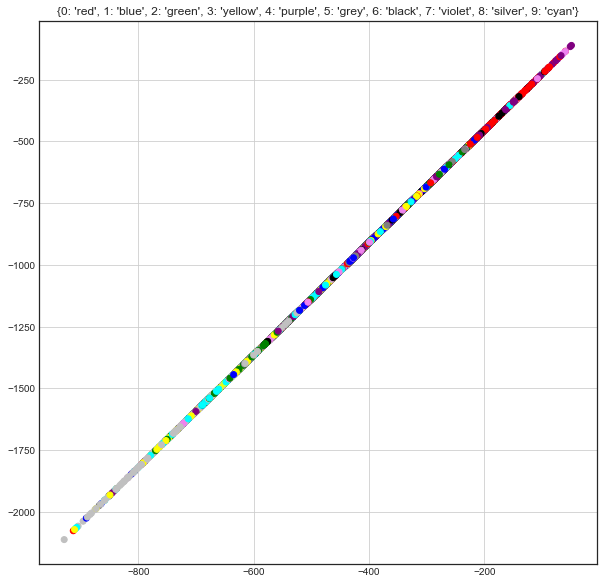

 iter: 1 batch: 10800 range: 0.0 recon cost: 0.2669485 zero cost: 0.012178733								 one  cost: 0.51989 fake cost: 5.820184228645

KeyboardInterrupt: 

In [13]:
# start the session
try:
    sess.run(tf.global_variables_initializer())
except:
    sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())
train_batch_shuffled = train_batch.copy()
color_dict = {0:'red',1:'blue',2:'green',3:'yellow',4:'purple',5:'grey',6:'black',7:'violet',8:'silver',9:'cyan'}

#                     00005
aimed_range_start = 0.00000
for iter in range(num_epoch):
    for current_data_index in range(0,len(train_batch),batch_size):
        prior_z      = np.random.normal(scale=3.0,size=(batch_size, 2)).astype(np.float32)
        current_data = train_batch_shuffled[current_data_index:current_data_index+batch_size].astype(np.float32)
    
        sess_result0 = sess.run([recon_cost,grad0_update],
        feed_dict={x0:current_data.reshape((batch_size,-1)),lr0:0.00002,aimed_range:aimed_range_start
        })

        sess_result1 = sess.run([dis_cost1,grad1_update],
        feed_dict={x1:current_data.reshape((batch_size,-1)),lr1:0.0001})

        sess_result2 = sess.run([dis_cost2,grad2_update],
        feed_dict={x2:prior_z                              ,lr2:0.0001})
        
        sess_result3 = sess.run([fake_cost,fake_grad_update],
        feed_dict={x3:current_data.reshape((batch_size,-1)),lr3:0.0005,aimed_range:aimed_range_start
                  })

        sys.stdout.write('\r iter: ' + str(iter) + ' batch: ' + str(current_data_index) + ' range: ' + str(aimed_range_start) + \
            ' recon cost: ' + str(sess_result0[0]) + \
            ' zero cost: ' + str(sess_result1[0]) + '\t\t\t\t\t\t\t\t' + \
            ' one  cost: ' + str(sess_result2[0]) + \
            ' fake cost: ' + str(sess_result3[0]) 
        ); sys.stdout.flush()
        
    aimed_range_start = aimed_range_start * 0.9    
    if iter % print_size == 0:
        random_idx = np.random.permutation(len(train_batch_shuffled))
        temp_data  = train_batch_shuffled[random_idx][:batch_size].reshape((batch_size,-1))
#         sess_result = sess.run(dlayer3,
#                       feed_dict={x0:temp_data }).reshape((batch_size,28,28))
#         fig=plt.figure(figsize=(15, 15)); columns = 10 ; rows = 1
#         for i in range(1, columns*rows +1):
#             fig.add_subplot(rows, columns, i)
#             if i % 2 ==0 :
#                   plt.imshow(np.squeeze(sess_result[i-2]),cmap='gray')
#             else:
#                 plt.imshow(np.squeeze(temp_data[i-1]).reshape((28,28)),cmap='gray')
#             plt.axis('off')
#         plt.show()
        
        # Show the latent space        
        all_latent_vectors = sess.run(elayer33,feed_dict={x3:train_batch[:batch_size].reshape((batch_size,-1))})
        for current_batch_index in range(batch_size,len(train_batch), batch_size):
            current_train_data = train_batch[current_batch_index:current_batch_index+batch_size]
            sess_results = sess.run(elayer33,feed_dict={x3:current_train_data.reshape((batch_size,-1))})
            all_latent_vectors = np.vstack((all_latent_vectors,sess_results))
        fig = plt.figure(figsize=(10,10))
        color_mapping = [color_dict[x] for x in np.argmax(train_label[:len(train_batch),:],1) ]
        plt.title(str(color_dict))
        plt.scatter(all_latent_vectors[:,0],all_latent_vectors[:,1],c=color_mapping)
#         plt.scatter(prior_z[:,0],prior_z[:,1],marker='^')
#         plt.xlim(-5,5);plt.ylim(-5,5);
        plt.grid();plt.show()

In [ ]:
# convert every data into latent to know the statistics
all_latent_vectors = sess.run(elayer3,feed_dict={x:train_batch[:batch_size].reshape((batch_size,-1))})
print(train_batch.shape)
print(all_latent_vectors.shape)
for current_batch_index in range(batch_size,len(train_batch), batch_size):
    current_train_data = train_batch[current_batch_index:current_batch_index+batch_size]
    sess_results = sess.run(elayer3,feed_dict={x:current_train_data.reshape((batch_size,-1))})
    all_latent_vectors = np.vstack((all_latent_vectors,sess_results))
print(all_latent_vectors.shape)

In [ ]:
# view the latent vectors
fig = plt.figure(figsize=(10,10))
color_dict = {
    0:'red',
    1:'blue',
    2:'green',
    3:'yellow',
    4:'purple',
    5:'grey',
    6:'black',
    7:'violet',
    8:'silver',
    9:'cyan',
}
color_mapping = [color_dict[x] for x in np.argmax(train_label[:len(train_batch),:],1) ]
plt.title(str(color_dict))
plt.scatter(all_latent_vectors[:,0],all_latent_vectors[:,1],c=color_mapping)
plt.grid()
plt.show()